# Using time to model a non-linear trend

In this notebook we show how to create a feature using time to capture the trend of a time series. We'll look at using powers of the time feature to create non-linear trends. We will use it to create some simple forecasts with a linear regression. 

In [1]:
import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sns.set_context("talk")

# Data set synopsis

The air passengers dataset is the monthly totals of international airline passengers, from 1949 to 1960, in units of 1000s. 

For instructions on how to download, prepare, and store the dataset, refer to notebook number 5, in the folder "01-Create-Datasets" from this repo.

In [2]:
data = pd.read_csv(
    "../Datasets/example_air_passengers.csv",
    parse_dates=["ds"],
    index_col=["ds"],
)

In [3]:
data.head()

,y
ds,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


## Plot the data

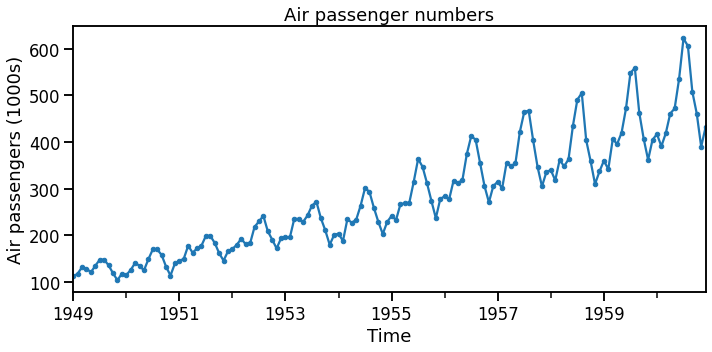

In [4]:
fig, ax = plt.subplots(figsize=[10, 5])
data.plot(y="y", marker=".", figsize=[10, 5], legend=None, ax=ax)
ax.set_xlabel("Time")
ax.set_ylabel("Air passengers (1000s)")
ax.set_title("Air passenger numbers")
plt.tight_layout()

# Let's create non-linear time features

Let's see how we can create these features with higher order terms such as $t^2$, $t^3$.

In [5]:
# Create a new copy of the original data.
df = data.copy()

Create the time feature (i.e., the time since the start of the time series).

In [6]:
# Requires version 0.14.1 or greater of sktime.
from sktime.transformations.series.time_since import TimeSince

In [7]:
time_since_transformer = TimeSince(keep_original_columns=True, freq="MS")

# Compute the time since the start of the time series
df = time_since_transformer.fit_transform(df)

df.head()

,y,time_since_1949-01-01 00:00:00
ds,,
1949-01-01,112,0
1949-02-01,118,1
1949-03-01,132,2
1949-04-01,129,3
1949-05-01,121,4


We could manually create these features.

In [8]:
df["t^2"] = df["time_since_1949-01-01 00:00:00"] ** 2
df.head()

,y,time_since_1949-01-01 00:00:00,t^2
ds,,,
1949-01-01,112,0,0
1949-02-01,118,1,1
1949-03-01,132,2,4
1949-04-01,129,3,9
1949-05-01,121,4,16


Alternatively, here is an example using the `PolynomialFeatures` transformer. By specifying `degree`, $d$, the transformer will output the following columns: $t$, $t^2$, ..., $t^d$.

In [9]:
# Let's ensure all sklearn transformers output pandas dataframes
from sklearn import set_config
from sklearn.preprocessing import PolynomialFeatures

set_config(transform_output="pandas")  # Upgrade to scikit-learn 0.12
                                       # for this feature

In [10]:
# Create and use the polynomial transformer.
poly_transformer = PolynomialFeatures(
    degree=2, # degree of polynomial
    include_bias=False  # exclude constant term
)

# Create polynomial features from a given column
result = poly_transformer.fit_transform(df[["time_since_1949-01-01 00:00:00"]])
result

,time_since_1949-01-01 00:00:00,time_since_1949-01-01 00:00:00^2
ds,,
1949-01-01,0.0,0.0
1949-02-01,1.0,1.0
1949-03-01,2.0,4.0
1949-04-01,3.0,9.0
1949-05-01,4.0,16.0
...,...,...
1960-08-01,139.0,19321.0
1960-09-01,140.0,19600.0
1960-10-01,141.0,19881.0


Let's create a single transformer that outputs our polynomial features for time.

In [11]:
from sklearn.pipeline import make_pipeline

In [12]:
time_feats = make_pipeline(
                           TimeSince(freq="MS"), 
                           PolynomialFeatures(degree=2, include_bias=False)
                          )

In [13]:
# Create a new copy of the original data.
df = data.copy()

In [14]:
result = time_feats.fit_transform(df)
result

,time_since_1949-01-01 00:00:00,time_since_1949-01-01 00:00:00^2
ds,,
1949-01-01,0.0,0.0
1949-02-01,1.0,1.0
1949-03-01,2.0,4.0
1949-04-01,3.0,9.0
1949-05-01,4.0,16.0
...,...,...
1960-08-01,139.0,19321.0
1960-09-01,140.0,19600.0
1960-10-01,141.0,19881.0


# Let's build a forecast with just these non-linear time features.

As with the previous notebook, in this notebook we will focus more on the impact of these features rather than the overall forecasting workflow. We will show the creation of these features in a recursive forecasting workflow in the next notebook. We will see what impact using higher order terms such as $t^2$, $t^3$, and so on can have.

In [15]:
# Create a new copy of the original data.
df = data.copy()

Let's split the data into train and test.

In [16]:
target = "y"
holdout_size = 12 * 6  # forecast horizon

# Use all the time up until the start
# of the forecast horizon for training.
df_train = df.iloc[:-holdout_size]

# Use the end of the time series
# to test.
df_test = df.iloc[-holdout_size:]

Create our feature engineering pipeline. Ridge and Lasso require feature scaling. Let's scale the features as well.

In [17]:
from sklearn.preprocessing import MinMaxScaler

In [18]:
# Specify degree of polynomial
degree = 3

time_feats = make_pipeline(
                            TimeSince(freq="MS"),
                            PolynomialFeatures(degree=degree, include_bias=False),
                            MinMaxScaler()
                          )

Create X and y

In [19]:
X_train = time_feats.fit_transform(df_train)
y_train = df_train[target]

X_test = time_feats.transform(df_test)
y_test = df_test[target]

X_test.head()

,time_since_1949-01-01 00:00:00,time_since_1949-01-01 00:00:00^2,time_since_1949-01-01 00:00:00^3
ds,,,
1955-01-01,1.014085,1.028367,1.042851
1955-02-01,1.028169,1.057132,1.086910
1955-03-01,1.042254,1.086292,1.132192
1955-04-01,1.056338,1.115850,1.178715
1955-05-01,1.070423,1.145804,1.226495


Build forecast. We have all the features in both train and test, we're not building features from the target variable. So we're not using either direct or recursive forecasting for multi-step forecasting here.

In [20]:
from sklearn.linear_model import Lasso, LinearRegression, Ridge

In [21]:
# Define the model.
model = LinearRegression()

# Fit model.
model.fit(X_train, y_train)

# Make forecast and convert to dataframes.
y_pred_train = model.predict(X_train)
y_pred_train = pd.DataFrame(y_pred_train, index=df_train.index)

y_pred_test = model.predict(X_test)
y_pred_test = pd.DataFrame(y_pred_test, index=df_test.index)

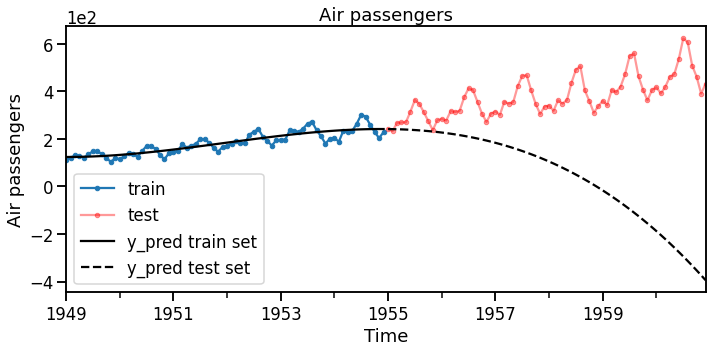

In [22]:
fig, ax = plt.subplots(figsize=[10, 5])

df_train[target].plot(ax=ax, marker=".")
df_test[target].plot(ax=ax, marker=".", color="r", alpha=0.4)

y_pred_train.plot(color="k", ax=ax)
y_pred_test.plot(color="k", ax=ax, linestyle="--")

ax.legend(["train", "test", "y_pred train set", "y_pred test set"])
ax.set_xlabel("Time")
ax.set_ylabel("Air passengers")
ax.set_title("Air passengers")
ax.ticklabel_format(style="sci", axis="y", scilimits=(0, 0))
plt.tight_layout()

In [23]:
# Examine model coefficients.
pd.Series(index=X_train.columns, data=model.coef_)

time_since_1949-01-01 00:00:00       -2.679744
time_since_1949-01-01 00:00:00^2    363.302794
time_since_1949-01-01 00:00:00^3   -243.127004
dtype: float64

In [24]:
# Compute error metrics.
from sklearn.metrics import mean_squared_error

print(mean_squared_error(df_train[target], y_pred_train, squared=False))
print(mean_squared_error(df_test[target], y_pred_test, squared=False))

22.864911883894223
419.58053886187


In general, it is not recommended to use $t^2$ terms or higher. But, we can see that regularisation can help. In practice, it's best to experiment and see which features produce the best forecast for your own use case.

In the next notebook we'll show how the time feature helps in addition to adding lag features in a more complex example where we will use recursive forecasting.